In [1]:
%matplotlib inline
import os
import numpy as np
import xarray as xr

import ncar_jobqueue
import dask
import dask.distributed
import cftime

import esmlab
import intake
import intake_esm

import matplotlib.pyplot as plt

import util

/glade/work/mclong/miniconda3/envs/dev/lib/python3.7/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/glade/work/mclong/miniconda3/envs/dev/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
cluster = ncar_jobqueue.NCARCluster(walltime='12:00:00')
client = dask.distributed.Client(cluster)
n_workers = 9 * 12
cluster.scale(n_workers)

In [3]:
#!qstat | grep dask-worker
!squeue | grep mclong | grep dask-wor

/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_ml'
           2523746       dav dask-wor   mclong PD       0:00      1 (None)


In [5]:
client

Client Scheduler: tcp://10.12.205.12:43917 Dashboard: http://10.12.205.12/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
molw_Fe = 55.845

kgm2s_to_molm2yr = 1e3 / molw_Fe * 86400. * 365.

In [5]:
col = intake.open_esm_metadatastore(collection_input_definition='collections.yml',
                                    overwrite_existing=True)

Working on experiment: ctrl
Getting file listing : scratch:posix:/glade/scratch/mclong/archive/g.e21.G1850ECOIAF.T62_g17.004
Building file database : scratch:posix:/glade/scratch/mclong/archive/g.e21.G1850ECOIAF.T62_g17.004
Working on experiment: xtfe
Getting file listing : scratch:posix:/glade/scratch/mclong/archive/g.e21.G1850ECOIAF.T62_g17.xtfe.001
Building file database : scratch:posix:/glade/scratch/mclong/archive/g.e21.G1850ECOIAF.T62_g17.xtfe.001
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1211 entries, 0 to 1210
Data columns (total 19 columns):
resource            1211 non-null object
resource_type       1211 non-null object
direct_access       1211 non-null object
description         1211 non-null object
experiment          1211 non-null object
case                1211 non-null object
component           1211 non-null object
stream              1211 non-null object
variable            1211 non-null object
date_range          1211 non-null object
ensemble            1211 non-null object
file_fullpath       1211 non-null object
file_basename       1211 non-null object
file_dirname        1211 non-null object
ctrl_branch_year    0 non-null object
year_offset         1211 non-null object
sequence_order      1211 non-null object
has_ocean_bgc       1211 non-null object
grid                1211 non-null object
dtypes: object(19)
memory usage: 179.8+ KB
Persisting xtfe-cesm-runs at : /glade/u/home/mclong/p/xtfe/intake-collecti

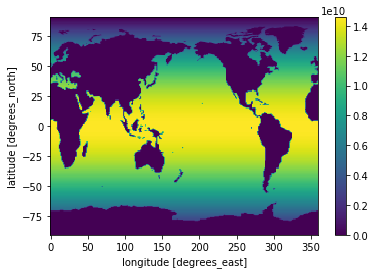

In [6]:
inputdata = '/glade/p/cesmdata/cseg/inputdata'

with xr.open_dataset(f'{inputdata}/atm/cam/ocnfrac/domain.camocn.0.9x1.25_gx1v7_170215.nc') as ds:
    OCNFRAC = ds.frac.rename({'nj': 'lat', 'ni': 'lon'})

with xr.open_dataset(f'{inputdata}/atm/cam/coords/fv_0.9x1.25.nc') as ds:
    AREA = xr.DataArray(util.compute_grid_area(ds).values, dims=('lat', 'lon'))
    lon = ds.lon
    lat = ds.lat

AREA['lon'] = lon
AREA['lat'] = lat
OCNFRAC['lon'] = lon
OCNFRAC['lat'] = lat
    
AREA = AREA * OCNFRAC

AREA.plot()

In [7]:
presaero_path = '/glade/work/mclong/cesm_cases/xtfe/data/forcing'
presaero_file = 'aerosoldep_WACCM.ensmean_monthly_hist_1849-2015_0.9x1.25_CMIP6_c180926-xtfe.nc'
ds5 = xr.open_dataset(f'{presaero_path}/{presaero_file}')

ds5 = ds5.sel(time='2000')

ds5['time_bnd_diff'] = xr.DataArray(np.diff(cftime.date2num(ds5.time_bnds, 
                                                            units='days since 0001-01-01', 
                                                            calendar='noleap'), axis=1)[:, 0]/365., 
                                    dims=('time'), 
                                    coords={'time': ds5.time})

ds5.time_bnd_diff['units'] = 'year'

# overwrite coords to deal with round-off level diffs
ds5['lon'] = lon
ds5['lat'] = lat
ds5 = ds5.reindex({'lat': lat, 'lon': lon})
ds5

<xarray.Dataset>
Dimensions:        (lat: 192, lon: 288, ntb: 2, time: 12)
Coordinates:
  * lat            (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon            (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time           (time) object 2000-01-16 12:00:00 ... 2000-12-16 12:00:00
Dimensions without coordinates: ntb
Data variables:
    BCDEPWET       (time, lat, lon) float32 5.856115e-16 ... 2.5941094e-14
    BCPHIDRY       (time, lat, lon) float32 7.165252e-17 ... 3.9884753e-15
    BCPHODRY       (time, lat, lon) float32 8.384732e-18 ... 1.0866273e-14
    DSTX01DD       (time, lat, lon) float32 3.4760406e-17 ... 3.7529557e-15
    DSTX01WD       (time, lat, lon) float32 3.5114018e-16 ... 1.3153321e-14
    DSTX02DD       (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    DSTX02WD       (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    DSTX03DD       (time, lat, lon) float32 2.1564233e-16 ... 4.3515725e-14
    DSTX03

## Load CESM simulation data

In [9]:
data_vars = ['IRON_FLUX', 'ATM_XTFE_FLUX_CPL', 'SEAICE_XTFE_FLUX_CPL', 'Fe']

ds = util.open_cesm_data(col, data_vars)

dsann = esmlab.resample(ds, freq='ann')
ds

xtfe: Ocean-ice hindcast, XT-Fe forcing 100% soluble
	vars: ['IRON_FLUX', 'ATM_XTFE_FLUX_CPL', 'SEAICE_XTFE_FLUX_CPL', 'Fe']
ctrl: Ocean-ice hindcast, control
	vars: ['IRON_FLUX', 'Fe']


<xarray.Dataset>
Dimensions:                 (d2: 2, experiment: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, time: 384, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
  * experiment              (experiment) <U4 'xtfe' 'ctrl'
  * time                    (time) object 0001-01-16 12:59:59 ... 0032-12-16 12:00:00
  * lat_aux_grid            (lat_aux_grid) float32 -79.48815 -78.952896 ... 90.0
  * moc_z                   (moc_z) float32 0.0 1000.0 ... 525000.94 549999.06
  * z_t                     (z_t) float32 500.0 1500.0 ... 512502.8 537500.0
  * z_t_150m                (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
  * z_w                     (z_w) float32 0.0 1000.0 ... 500004.7 525000.94
  * z_w_bot                 (z_w_bot) float32 1000.0 2000.0 ... 549999.06
  * z_w_top                 (z_w_top) float32 0.0 1000.0 ... 500004.7 525000.94
Dimensions without coordinates: d2, moc_comp, nlat, nlon

## Compare XT Fe global integrals

### "Truth": computed directly from forcing dataset

In [10]:
datm_xtfe_glb = esmlab.weighted_sum(ds5.EXTTERFE * kgm2s_to_molm2yr, weights=AREA, dim=['lat', 'lon']) * 1e-9 # mol --> Gmol
datm_xtfe_glb = esmlab.weighted_sum(datm_xtfe_glb, weights=ds5.time_bnd_diff, dim=('time'))
print(f'Annual global XT Fe deposition: {datm_xtfe_glb.values:0.6f} Gmol')


Annual global XT Fe deposition: 0.064768 Gmol


### Computed from difference in `IRON_FLUX` variable between `xtfe` and `ctrl`

Since the model is using a repeating annual cycle, an average over all years helps smooth out some of the temporal shifting of the flux mediating by sea ice.

In [11]:
xtfe_flux = ds.IRON_FLUX.sel(experiment='xtfe') - ds.IRON_FLUX.sel(experiment='ctrl')

pop_xtfe_glb = esmlab.weighted_sum(xtfe_flux, weights=ds.TAREA*1e-4, dim=['nlat', 'nlon']) * 1e-9 # mol --> Gmol
pop_xtfe_glb = esmlab.weighted_sum(pop_xtfe_glb, weights=ds.time_bound_diff, dim=('time'))

pop_xtfe_glb = pop_xtfe_glb / (len(ds.time) / 12)
print(f'Annual global XT Fe deposition: {pop_xtfe_glb.values:0.6f}')


Annual global XT Fe deposition: 0.064815


### Computed from fields from the coupler

In [12]:
xtfe_flux = (ds.ATM_XTFE_FLUX_CPL + ds.SEAICE_XTFE_FLUX_CPL) 

pop_xtfe_glb = esmlab.weighted_sum(xtfe_flux, weights=ds.TAREA*1e-4, dim=['nlat', 'nlon']) * 1e-9 # mol --> Gmol
pop_xtfe_glb = esmlab.weighted_sum(pop_xtfe_glb, weights=ds.time_bound_diff, dim=('time'))

pop_xtfe_glb = pop_xtfe_glb / (len(ds.time) / 12)

print(f'Annual global XT Fe deposition: {pop_xtfe_glb.values:0.6f}')


Annual global XT Fe deposition: 0.064814


### Compute timeseries of Southern Ocean dFe

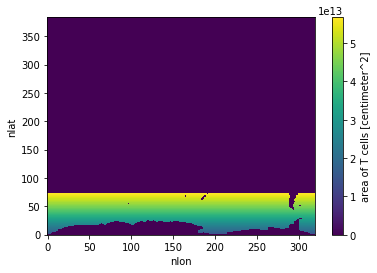

In [15]:
rmask = dsann.TAREA.where((dsann.TLAT < -40) & (dsann.KMT > 0)).fillna(0.)
rmask.plot()

In [25]:
dz_mask = dsann.dz.where(dsann.z_t < 200e2).fillna(0.)

In [26]:
dFe_so = esmlab.weighted_mean(dsann.Fe, weights=dz_mask * rmask, 
                             dim=['z_t', 'nlat', 'nlon']).compute()



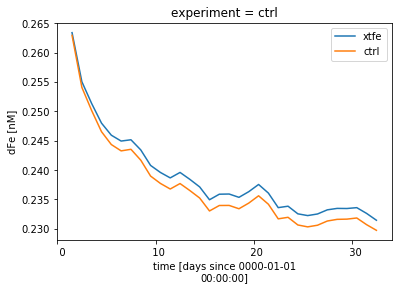

In [27]:
for exp in dFe_so.experiment.values:
    dFe_so.sel(experiment=exp).plot(label=exp)
plt.legend()